In [ ]:
#list of useful imports that  I will use
%matplotlib inline
import os
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns
import random
from keras.preprocessing import image
import tensorflow as tf

#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
#from keras.optimizers import RMSprop
#from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, GRU, TimeDistributed, Reshape

In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file = '/content/drive/MyDrive/face_emotion.zip'

In [ ]:
import zipfile as zf
data_zip = zf.ZipFile(file)
data_zip.extractall()
!ls

CK+48  drive  sample_data


In [ ]:
data = 'CK+48'

In [ ]:
#in this we import all the images to the Images.
#in this we append img to images

Images = []
import os
for dirname, _, filenames in os.walk(data):
    for filename in filenames:
        img = os.path.join(dirname, filename)
        Images.append(img)

In [ ]:
Images[:10]

['CK+48/happy/S135_012_00000020.png',
 'CK+48/happy/S053_004_00000022.png',
 'CK+48/happy/S137_011_00000018.png',
 'CK+48/happy/S135_012_00000018.png',
 'CK+48/happy/S069_004_00000015.png',
 'CK+48/happy/S085_002_00000013.png',
 'CK+48/happy/S100_006_00000016.png',
 'CK+48/happy/S062_004_00000022.png',
 'CK+48/happy/S083_003_00000019.png',
 'CK+48/happy/S060_002_00000026.png']

In [ ]:
len(Images)

981

In [ ]:
#in this we append class label names only
#anger only is append

Class_label = []
for i in Images:
  j = i.split("/")
  #print(j[1])
  Class_label.append(j[1])


In [ ]:
Class_label[:10]

['happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy']

In [ ]:
len(Class_label)

981

In [ ]:
# Shuffle two lists with same order
# Using zip() + * operator + shuffle()
#by using this we combine both by using the zip
#[img1,cat],[img2,dog]by using this we come like this
temp = list(zip(Images, Class_label))
random.shuffle(temp)
Images, Class_label = zip(*temp)

In [ ]:
data = pd.DataFrame(list(zip(Images, Class_label)), columns =['Image_path', 'Class_label'])

In [ ]:
data.shape

(981, 2)

In [ ]:
data.head(10)

,Image_path,Class_label
0,CK+48/happy/S128_011_00000014.png,happy
1,CK+48/surprise/S122_001_00000011.png,surprise
2,CK+48/sadness/S042_002_00000016.png,sadness
3,CK+48/happy/S042_006_00000015.png,happy
4,CK+48/surprise/S057_001_00000019.png,surprise
5,CK+48/fear/S999_003_00000054.png,fear
6,CK+48/surprise/S042_001_00000017.png,surprise
7,CK+48/surprise/S059_001_00000017.png,surprise
8,CK+48/sadness/S506_006_00000041.png,sadness
9,CK+48/surprise/S078_001_00000031.png,surprise


In [ ]:
data.Class_label.value_counts()

,count
Class_label,
surprise,249
happy,207
disgust,177
anger,135
sadness,84
fear,75
contempt,54


In [ ]:
from sklearn.utils import resample
#seperate majority and minority classses
df_c0=data[data["Class_label"]=="surprise"]
df_c1=data[data["Class_label"]=="happy"]
df_c3=data[data["Class_label"]=="anger"]
df_c4=data[data["Class_label"]=="sadness"]
df_c5=data[data["Class_label"]=="fear"]       #we take top 3 as majority class and remove the one least one from them

#top 3 majority class has 249,207,177,we remove 177
#top 4 minority class has 135,84,75,54 we remove 54


#upsample majority class
df_c0_upsampled=resample(df_c0,replace=True,n_samples=500,random_state=123)#we convert samples into the 500 each one
df_c1_upsampled=resample(df_c1,replace=True,n_samples=500,random_state=123)
df_c3_upsampled=resample(df_c3,replace=True,n_samples=500,random_state=123)
df_c4_upsampled=resample(df_c4,replace=True,n_samples=500,random_state=123)
df_c5_upsampled=resample(df_c5,replace=True,n_samples=500,random_state=123)


#combine minority class with downsampled majority class
df_upsampled=pd.concat([df_c0_upsampled,df_c1_upsampled,df_c3_upsampled,df_c4_upsampled,df_c5_upsampled])

#Display new class counts

df_upsampled["Class_label"].value_counts()

,count
Class_label,
surprise,500
happy,500
anger,500
sadness,500
fear,500


<ipython-input-18-0166c3922a28>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(x="Class_label",data=df_upsampled,palette=sns.color_palette("cubehelix",4))
<ipython-input-18-0166c3922a28>:4: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  ax=sns.countplot(x="Class_label",data=df_upsampled,palette=sns.color_palette("cubehelix",4))


Text(0.5, 0, 'Class_label')

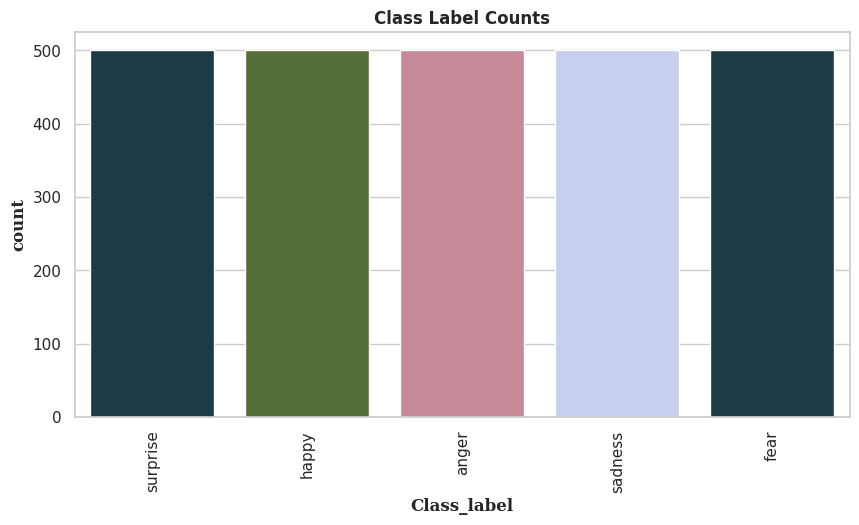

In [ ]:
#counts of top 10 drugs
sns.set(style="whitegrid")
plt.figure(figsize=(10,5))
ax=sns.countplot(x="Class_label",data=df_upsampled,palette=sns.color_palette("cubehelix",4))
plt.xticks(rotation=90)
plt.title("Class Label Counts", {"fontname":"fantasy", "fontweight":"bold", "fontsize":"medium"})
plt.ylabel("count", {"fontname": "serif", "fontweight":"bold"})
plt.xlabel("Class_label", {"fontname": "serif", "fontweight":"bold"})

In [ ]:
#shuffle the data or mixed the data frac=1 is used for that
data=df_upsampled.sample(frac=1)

In [ ]:
data.head()


,Image_path,Class_label
155,CK+48/anger/S032_003_00000017.png,anger
246,CK+48/anger/S112_005_00000016.png,anger
647,CK+48/sadness/S115_004_00000016.png,sadness
242,CK+48/surprise/S081_001_00000017.png,surprise
636,CK+48/happy/S063_002_00000022.png,happy


# **RESIZE THE IMAGE**

In [ ]:
def resize_images(img):
  #file=image.open(img)
  file=cv2.imread(img)
  #img=file.convert("RGB")
  #img_bgr=img.resize((48,48))
  resized=cv2.resize(file,(48,48),interpolation=cv2.INTER_AREA)#here by using this we convert all images in to 48,48 size only
  img_bgr=np.array(resized)
  return img_bgr

In [ ]:
from PIL import Image

In [ ]:
images=[resize_images(img)for img in data["Image_path"]]

In [ ]:
len(images)


2500

array([[[ 42,  42,  42],
        [ 44,  44,  44],
        [ 59,  59,  59],
        ...,
        [ 49,  49,  49],
        [ 49,  49,  49],
        [ 51,  51,  51]],

       [[ 39,  39,  39],
        [ 42,  42,  42],
        [ 45,  45,  45],
        ...,
        [ 40,  40,  40],
        [ 49,  49,  49],
        [ 47,  47,  47]],

       [[ 35,  35,  35],
        [ 32,  32,  32],
        [ 34,  34,  34],
        ...,
        [ 38,  38,  38],
        [ 43,  43,  43],
        [ 44,  44,  44]],

       ...,

       [[ 80,  80,  80],
        [ 87,  87,  87],
        [ 83,  83,  83],
        ...,
        [237, 237, 237],
        [189, 189, 189],
        [ 81,  81,  81]],

       [[ 84,  84,  84],
        [ 87,  87,  87],
        [ 81,  81,  81],
        ...,
        [252, 252, 252],
        [159, 159, 159],
        [ 73,  73,  73]],

       [[ 84,  84,  84],
        [ 84,  84,  84],
        [ 80,  80,  80],
        ...,
        [248, 248, 248],
        [149, 149, 149],
        [ 68,  68,  68]]], dtype=uint8)
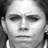

In [ ]:
images[0]


In [ ]:
#print number of classes in our dataset
num_classes=len(np.unique(data["Class_label"]))


In [ ]:
num_classes

5

In [ ]:
#save the class into class_names
class_names=list(data["Class_label"])


array([[[ 42,  42,  42],
        [ 44,  44,  44],
        [ 59,  59,  59],
        ...,
        [ 49,  49,  49],
        [ 49,  49,  49],
        [ 51,  51,  51]],

       [[ 39,  39,  39],
        [ 42,  42,  42],
        [ 45,  45,  45],
        ...,
        [ 40,  40,  40],
        [ 49,  49,  49],
        [ 47,  47,  47]],

       [[ 35,  35,  35],
        [ 32,  32,  32],
        [ 34,  34,  34],
        ...,
        [ 38,  38,  38],
        [ 43,  43,  43],
        [ 44,  44,  44]],

       ...,

       [[ 80,  80,  80],
        [ 87,  87,  87],
        [ 83,  83,  83],
        ...,
        [237, 237, 237],
        [189, 189, 189],
        [ 81,  81,  81]],

       [[ 84,  84,  84],
        [ 87,  87,  87],
        [ 81,  81,  81],
        ...,
        [252, 252, 252],
        [159, 159, 159],
        [ 73,  73,  73]],

       [[ 84,  84,  84],
        [ 84,  84,  84],
        [ 80,  80,  80],
        ...,
        [248, 248, 248],
        [149, 149, 149],
        [ 68,  68,  68]]], dtype=uint8)
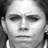

In [ ]:
images[0]

Text(0.5, 1.0, 'surprise')

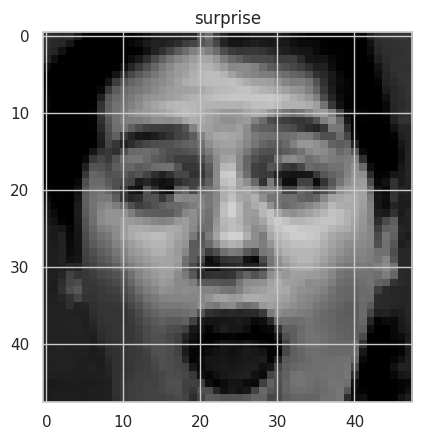

In [ ]:
#see the image with class label
plt.imshow(images[5])
plt.title(class_names[5])


Text(0.5, 1.0, 'happy')

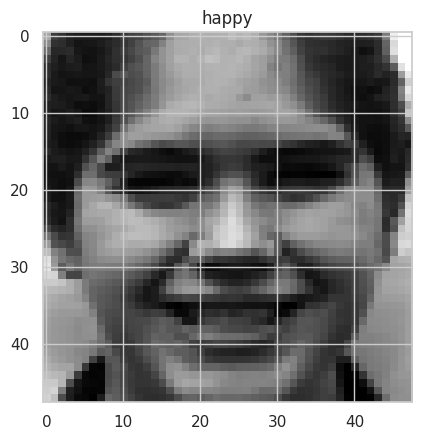

In [ ]:
#See the image with class label
plt.imshow(images[10])
plt.title(class_names[10])

Text(0.5, 1.0, 'surprise')

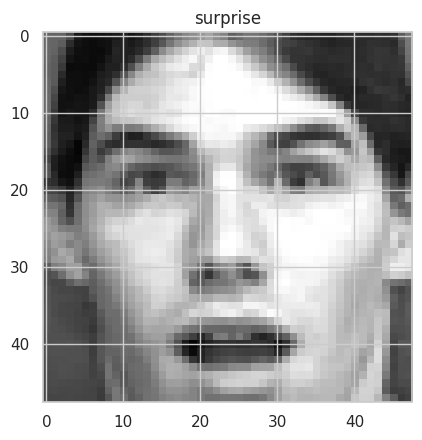

In [ ]:
#See the image with class label
plt.imshow(images[400])
plt.title(class_names[400])

Text(0.5, 1.0, 'fear')

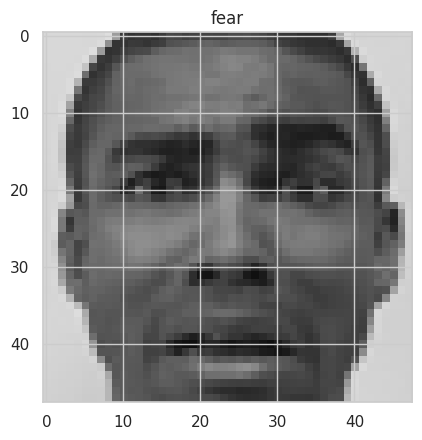

In [ ]:
#See the image with class label
plt.imshow(images[70])
plt.title(class_names[70])

# **LABEL ENCODER**

In [ ]:
from sklearn.preprocessing import LabelBinarizer
enc=LabelBinarizer()
y=enc.fit_transform(data["Class_label"])
#by using this we convert to label encoder

In [ ]:
data["Class_label"][:10]

,Class_label
155,anger
246,anger
647,sadness
242,surprise
636,happy
347,surprise
897,happy
952,surprise
401,surprise
763,fear


In [ ]:
images=np.array(images)#CONVERT INTO THE ARRAY

In [ ]:
images.shape

(2500, 48, 48, 3)

In [ ]:
y.shape

(2500, 5)

In [ ]:
y

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

# **SPLITING DATA INTO TRAINING AND TESTING**

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(images,y,test_size=0.3,stratify=y,random_state=42)

In [ ]:
x_train.shape

(1750, 48, 48, 3)

In [ ]:
x_test.shape

(750, 48, 48, 3)

# **cnn  model**

In [ ]:



# ... (rest of the code remains the same until the model definition)


# # **RNN model**
model = Sequential()#it build the neural network sequential

# Reshape the input to match the expected format for LSTM (samples, timesteps, features)
model.add(Reshape((48, 48*3), input_shape=(48, 48, 3))) # Assuming images are 48x48 with 3 color channels

# LSTM Layer
model.add(LSTM(units=128, return_sequences=True))  # 128 units in the LSTM layer, return sequences for stacking more layers
model.add(Dropout(0.2))

# Another LSTM layer (optional)
model.add(LSTM(units=64))  # 64 units in the second LSTM layer
model.add(Dropout(0.2))

# Dense layers for classification
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 48, 144)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 48, 128)             │         139,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,109 (809.02 KB)

 Trainable params: 207,109 (809.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import warnings
warnings.filterwarnings("ignore")#it remove the warnings

In [ ]:
#fit the model
history=model.fit(x_train,y_train,epochs=20,validation_data=(x_test,y_test),batch_size=128) #here we take the epochs

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accuracy: 0.2085 - loss: 1.6063 - val_accuracy: 0.3853 - val_loss: 1.5214
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.3852 - loss: 1.4768 - val_accuracy: 0.5053 - val_loss: 1.1978
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - accuracy: 0.5038 - loss: 1.2475 - val_accuracy: 0.5707 - val_loss: 1.0522
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.5723 - loss: 1.0607 - val_accuracy: 0.6600 - val_loss: 0.8969
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.6135 - loss: 0.9523 - val_accuracy: 0.7000 - val_loss: 0.7679
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.6606 - loss: 0.8501 - val_accuracy: 0.7920 - val_loss: 0.6689
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.6620 - loss: 0.8189 - val_accuracy: 0.7253 - val_loss: 0.6561
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.6574 - loss: 0.7917 - val_accuracy: 0

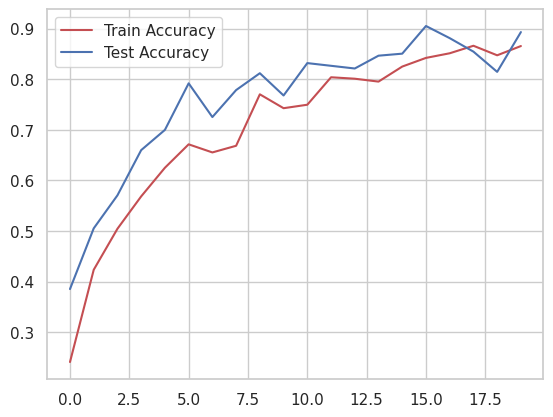

In [ ]:
#plot the accuracy plot
plt.plot(history.history["accuracy"], "r")
plt.plot(history.history["val_accuracy"],"b")
plt.legend({"Train Accuracy":"r","Test Accuracy":"b"})
plt.show()

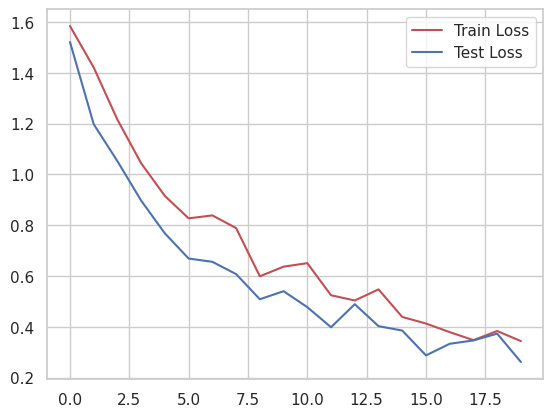

In [ ]:
#plot the accuracy plot
plt.plot(history.history["loss"],"r")
plt.plot(history.history["val_loss"],"b")
plt.legend({"Train Loss":"r","Test Loss":"b"})
plt.show()

In [ ]:
#print the test accuracy
score_1=model.evaluate(x_test,y_test,verbose=0)
print("Test accuracy:",score_1[1])

Test accuracy: 0.8933333158493042


In [ ]:
results=pd.DataFrame(columns=["Model","Test Accuracy"])


In [ ]:
new=["CNN",score_1[1]]
results.loc[1]=new

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


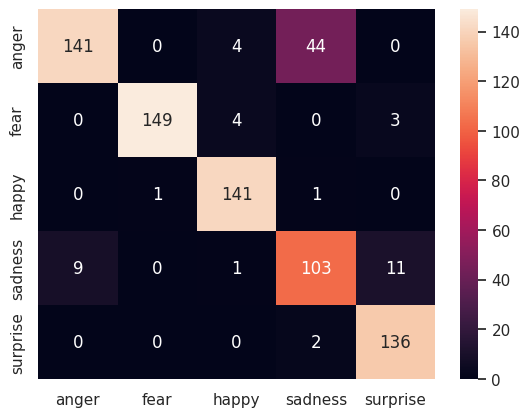

In [ ]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
class_names=enc.classes_
df_heatmap=pd.DataFrame(confusion_matrix(np.argmax(model.predict(x_test),axis=1),np.argmax(y_test,axis=1)),columns=class_names,index=class_names)
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

In [ ]:
df_heatmap

,anger,fear,happy,sadness,surprise
anger,141,0,4,44,0
fear,0,149,4,0,3
happy,0,1,141,1,0
sadness,9,0,1,103,11
surprise,0,0,0,2,136


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


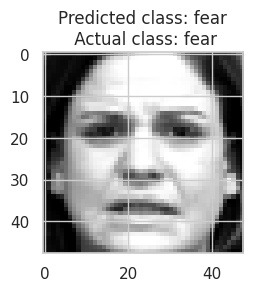

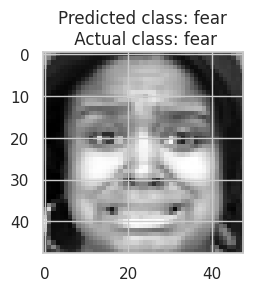

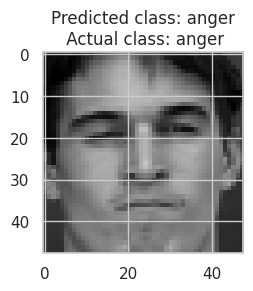

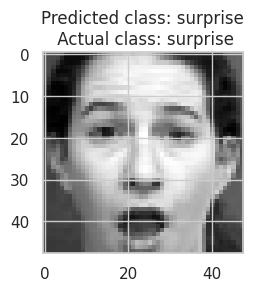

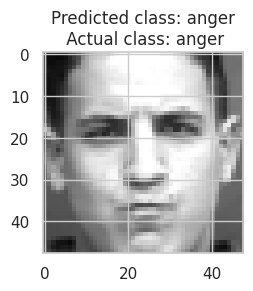

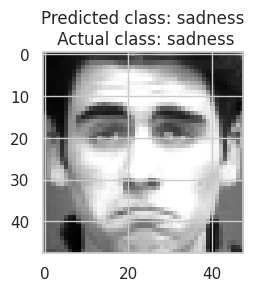

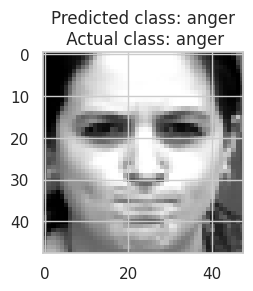

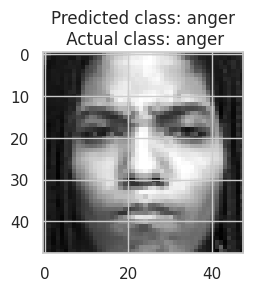

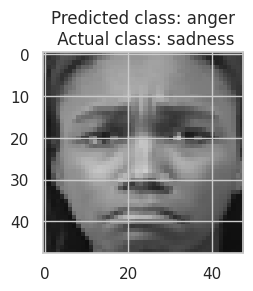

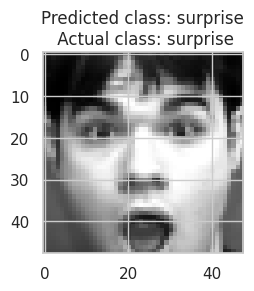

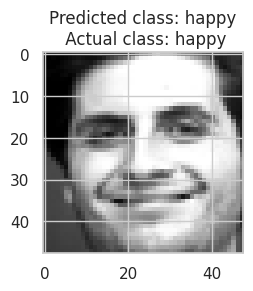

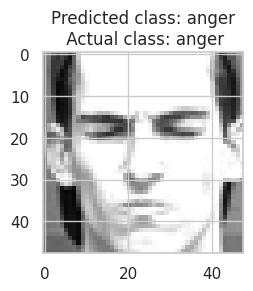

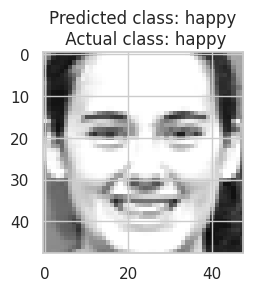

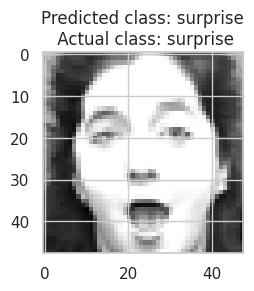

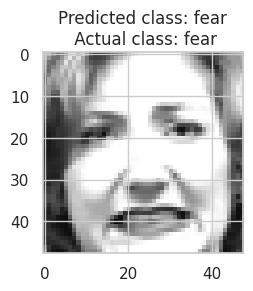

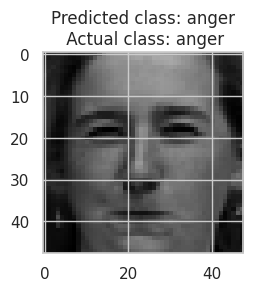

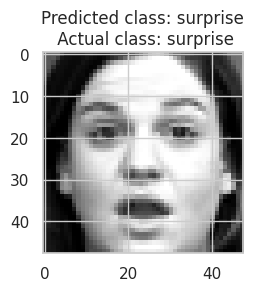

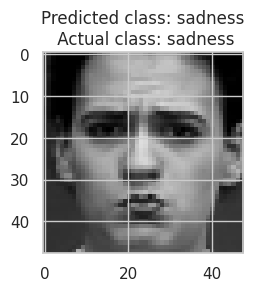

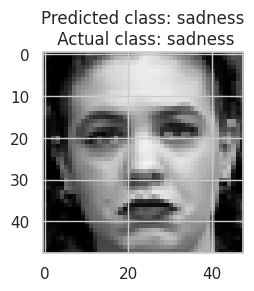

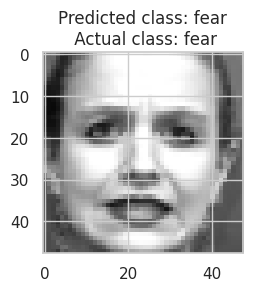

In [ ]:
#print images with actual and predicted class labels
# print images with actiual abnd predicted class labels
for i in range(20):
  plt.figure(figsize=(15,15))
  plt.subplot(4,5,i+1)
  pred = model.predict(np.array([x_test[i]]))[0]
  pred = np.argmax(pred)
  act = np.argmax(y_test[i])
  plt.title("Predicted class: {}\n Actual class: {}".format(enc.classes_[pred],enc.classes_[act]))
  # plt.title("Actual class: {}".format(enc.classes_[act]))
  plt.imshow(x_test[i])

# **VGG_16 MODEL**

In [ ]:
from keras.applications.vgg16 import VGG16
vgg=VGG16(weights="imagenet",include_top=False,input_shape=(48,48,3))
vgg.trainable=False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#set the vgg16 model
model_1=Sequential()
model_1.add(vgg)
model_1.add(Flatten())
model_1.add(Dense(128,activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Dense(5,activation="softmax"))

In [ ]:
#compile the model
model_1.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
History_1=model_1.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test),batch_size=128)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.2571 - loss: 12.0998 - val_accuracy: 0.5720 - val_loss: 2.1630
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - accuracy: 0.5319 - loss: 3.5756 - val_accuracy: 0.7640 - val_loss: 1.0621
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 0.6671 - loss: 2.1780 - val_accuracy: 0.8413 - val_loss: 0.6404
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.7339 - loss: 1.4395 - val_accuracy: 0.8773 - val_loss: 0.4713
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 100s 7s/step - accuracy: 0.8127 - loss: 0.8424 - val_accuracy: 0.9160 - val_loss: 0.3362
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.8454 - loss: 0.6096 - val_accuracy: 0.9307 - val_loss: 0.1924
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 0.8584 - loss: 0.5651 - val_accuracy: 0.9387 - val_loss: 0.1512
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.8793 - loss: 0.4321 - val_accuracy: 0.9573 - va

In [ ]:
# print the test accuracy
score_2 = model_1.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score_2[1])

In [ ]:
new = ['VGG-16 ',score_2[1]]
results.loc[2] = new

In [ ]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
class_names = enc.classes_
df_heatmap = pd.DataFrame(confusion_matrix(np.argmax(model_1.predict(x_test),axis = 1),np.argmax(y_test,axis=1)),columns=class_names, index = class_names)
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
# plot the accuracy plot
plt.plot(History_1.history['accuracy'], 'r')
plt.plot(History_1.history['val_accuracy'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()

In [ ]:
# plot the accuracy plot
plt.plot(History_1.history['loss'], 'r')
plt.plot(History_1.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [ ]:
# print images with actiual abnd predicted class labels
for i in range(20):
  plt.figure(figsize=(15,15))
  plt.subplot(4,5,i+1)
  pred = model_1.predict(np.array([x_test[i]]))[0]
  pred = np.argmax(pred)
  act = np.argmax(y_test[i])
  plt.title("Predicted class: {}\n Actual class: {}".format(enc.classes_[pred],enc.classes_[act]))
  # plt.title("Actual class: {}".format(enc.classes_[act]))
  plt.imshow(x_test[i])

## ***VGG_19 MODEL***

In [ ]:
# import the vgg16 model
from keras.applications.vgg19 import VGG19


In [ ]:
vgg=VGG19(weights='imagenet',include_top=False,input_shape=(48,48,3))

In [ ]:
#Fit the data or train the model
History_1 = model_1.fit(x_train, y_train, epochs = 20, validation_data = (x_test,y_test),batch_size = 128)

In [ ]:
# print the test accuracy
score_2 = model_1.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score_2[1])

In [ ]:
new = ['VGG-19 ',score_2[1]]
results.loc[3] = new

In [ ]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
class_names = enc.classes_
df_heatmap = pd.DataFrame(confusion_matrix(np.argmax(model_1.predict(x_test),axis = 1),np.argmax(y_test,axis=1)),columns=class_names, index = class_names)
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
# plot the accuracy plot
plt.plot(History_1.history['accuracy'], 'r')
plt.plot(History_1.history['val_accuracy'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()

In [ ]:
# plot the accuracy plot
plt.plot(History_1.history['loss'], 'r')
plt.plot(History_1.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [ ]:
# print images with actiual abnd predicted class labels
for i in range(20):
  plt.figure(figsize=(15,15))
  plt.subplot(4,5,i+1)
  pred = model_1.predict(np.array([x_test[i]]))[0]
  pred = np.argmax(pred)
  act = np.argmax(y_test[i])
  plt.title("Predicted class: {}\n Actual class: {}".format(enc.classes_[pred],enc.classes_[act]))
  # plt.title("Actual class: {}".format(enc.classes_[act]))
  plt.imshow(x_test[i])

# **MOBILE NET**

In [ ]:
# import the vgg16 model
from keras.applications.mobilenet import MobileNet
#from tf.keras.applications.mobilenet.MobileNet

In [ ]:
mob=MobileNet(weights='imagenet',include_top=False,input_shape=(48,48,3))

In [ ]:
mob.trainable=False

In [ ]:
# Set the vgg16 model

model_1=Sequential()
model_1.add(mob)
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(5, activation='softmax'))

In [ ]:
#Compile the model
model_1.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
from tensorflow.keras.utils import plot_model # Import plot_model from the correct location
plot_model(model_1, to_file='model_plot.png', show_shapes=False, show_layer_names=True)

In [ ]:
#Fit the data or train the model
History_1 = model_1.fit(x_train, y_train, epochs = 20, validation_data = (x_test,y_test),batch_size = 128)

In [ ]:
# print the test accuracy
score_2 = model_1.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score_2[1])


In [ ]:
new = ['Mobile Net ',score_2[1]]
results.loc[4] = new

In [ ]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
class_names = enc.classes_
df_heatmap = pd.DataFrame(confusion_matrix(np.argmax(model_1.predict(x_test),axis = 1),np.argmax(y_test,axis=1)),columns=class_names, index = class_names)
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
# plot the accuracy plot
plt.plot(History_1.history['accuracy'], 'r')
plt.plot(History_1.history['val_accuracy'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()

In [ ]:
# plot the accuracy plot
plt.plot(History_1.history['loss'], 'r')
plt.plot(History_1.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [ ]:
# print images with actiual abnd predicted class labels
for i in range(20):
  plt.figure(figsize=(15,15))
  plt.subplot(4,5,i+1)
  pred = model_1.predict(np.array([x_test[i]]))[0]
  pred = np.argmax(pred)
  act = np.argmax(y_test[i])
  plt.title("Predicted class: {}\n Actual class: {}".format(enc.classes_[pred],enc.classes_[act]))
  # plt.title("Actual class: {}".format(enc.classes_[act]))
  plt.imshow(x_test[i])

# *PERFORMANCE TABLE*

In [ ]:
results